<a href="https://colab.research.google.com/github/pangtengg/garbage-classifier/blob/main/Garbage_Classifier_Resnet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Garbage Classification

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


https://www.kaggle.com/datasets/126ab2c7f7e22add276bc29e44b97f635e3f6a04368afb20130a83518a9056b9

In [ ]:
!pip install torchsummary

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import json
from torchsummary import summary
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from collections import Counter
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
import cv2
from tqdm import tqdm

Configuration

In [ ]:
image_size = 224
batch_size = 32
num_workers = 2
learning_rate = 1e-5
num_epoch = 10

Data Loading

In [7]:
import os

dataset_path = "/content/drive/MyDrive/Colab Notebooks/garbage_classification"

# Check if path exists
if os.path.exists(dataset_path):
    print("✅ Path exists!")
else:
    print("❌ Path does NOT exist. Check the path.")


✅ Path exists!


In [8]:
# Load the dataset
full_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/Colab Notebooks/garbage_classification')

Splitting Data into Training and Testing Set

In [9]:
pip install scikit-learn

In [10]:
# Get the image paths and corresponding labels
# image_paths = np.array([sample[0] for sample in dataset.samples])
# Extract labels and split indices
labels = np.array([s[1] for s in full_dataset.samples])

# Perform stratified train-val split (80% train, 20% val)
train_idx, val_idx = train_test_split(
    np.arange(len(labels)), test_size=0.2, stratify=labels)

In [24]:
train_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(p=0.5),  # Data Augmentation
    transforms.RandomRotation(15),      # Data Augmentation
    transforms.RandomResizedCrop(image_size, scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor()
])

val_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor()
])

In [25]:
# Create subsets and apply transforms using a wrapper
class TransformSubset(torch.utils.data.Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)

# Create subsets from the full dataset
train_subset = torch.utils.data.Subset(full_dataset, train_idx)
val_subset = torch.utils.data.Subset(full_dataset, val_idx)

In [26]:
# Apply transforms to each subset
train_set = TransformSubset(train_subset, transform=train_transform)
val_set = TransformSubset(val_subset, transform=val_transform)

In [27]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                           shuffle=True, num_workers=num_workers)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size,
                                         shuffle=False, num_workers=num_workers)

In [28]:
print(f'Training set size: {len(train_set)}')
print(f'Test set size: {len(val_set)}')

# Function to count samples per class
def count_samples_per_class(dataset):
    labels = [label for _, label in dataset]
    label_count = Counter(labels)
    return label_count

Training set size: 12412
Test set size: 3103


In [29]:
# label_count = count_samples_per_class(train_set)
# num_classes = len(label_count)
# print("Total number of data: ", len(train_set))
# print("Number of classes:", num_classes)
# print("Number of data samples per class:", label_count)

In [30]:
# label_count = count_samples_per_class(val_set)
# num_classes = len(label_count)
# print("Total number of data: ", len(val_set))
# print("Number of classes:", num_classes)
# print("Number of data samples per class:", label_count)

Dataset Visualisation

In [31]:
from collections import Counter

# Count the distribution of classes in the training set
train_labels = [full_dataset.targets[i] for i in train_idx]
train_class_counts = Counter(train_labels)

# Count the distribution of classes in the test set
val_labels = [full_dataset.targets[i] for i in val_idx]
val_class_counts = Counter(val_labels)

print(f'Training set class distribution: {train_class_counts}')
print(f'Test set class distribution: {val_class_counts}')

Training set class distribution: Counter({4: 4260, 9: 1582, 7: 840, 1: 788, 0: 756, 3: 713, 8: 692, 11: 620, 6: 615, 10: 558, 5: 503, 2: 485})
Test set class distribution: Counter({4: 1065, 9: 395, 7: 210, 1: 197, 0: 189, 3: 178, 8: 173, 11: 155, 6: 154, 10: 139, 5: 126, 2: 122})


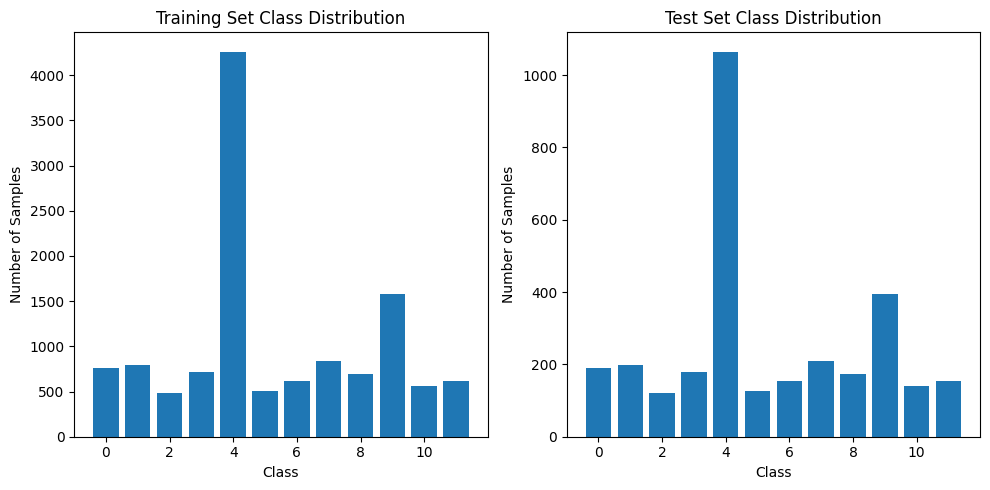

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# training set class distribution
axes[0].bar(train_class_counts.keys(), train_class_counts.values())
axes[0].set_title('Training Set Class Distribution')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Number of Samples')

# test set class distribution
axes[1].bar(val_class_counts.keys(), val_class_counts.values())
axes[1].set_title('Test Set Class Distribution')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Number of Samples')

plt.tight_layout()
plt.show()

Sample Images

In [33]:
garbage_class = {
    0: 'battery', 1: 'biological', 2: 'brown-glass', 3: 'cardboard', 4: 'clothes',
    5: 'green-glass', 6: 'metal', 7: 'paper', 8: 'plastic', 9: 'shoes',
    10: 'trash', 11: 'white-glass'}

def imshow(img_tensor, ax, label):
    """ Utility function to display an image tensor with a caption. """
    if img_tensor.shape[0] == 3:  # Check if it's an RGB image
        ax.imshow(img_tensor.permute(1, 2, 0))  # Reorder dimensions to (height, width, channels)
    else:
        ax.imshow(img_tensor.permute(1, 2, 0), cmap='gray')  # Display the first channel (grayscale)
    ax.axis('off')
    ax.set_title(label, fontsize=10)

def show_images_batch(images_batch, labels):
    """
    Display a batch of images in a grid with labels.
    """
    batch_size = images_batch.shape[0]
    grid_cols = int(np.ceil(np.sqrt(batch_size)))
    grid_rows = int(np.ceil(batch_size / grid_cols))  # Ensure all images fit in the grid

    fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(grid_cols * 2.5, grid_rows * 2.5))
    if grid_rows * grid_cols == 1:  # Special case for single image
        axes = np.array([axes])  # Make it iterable

    # Check if axes is still not iterable
    if not isinstance(axes, np.ndarray):
        axes = np.array([axes])

    for i in range(grid_rows * grid_cols):
        ax = axes.flatten()[i]
        if i < batch_size:
            # imshow(images_batch[i], ax, labels[i].item())
            imshow(images_batch[i], ax, garbage_class[labels[i].item()])
        else:
            ax.axis('off')

    plt.tight_layout()
    plt.show()

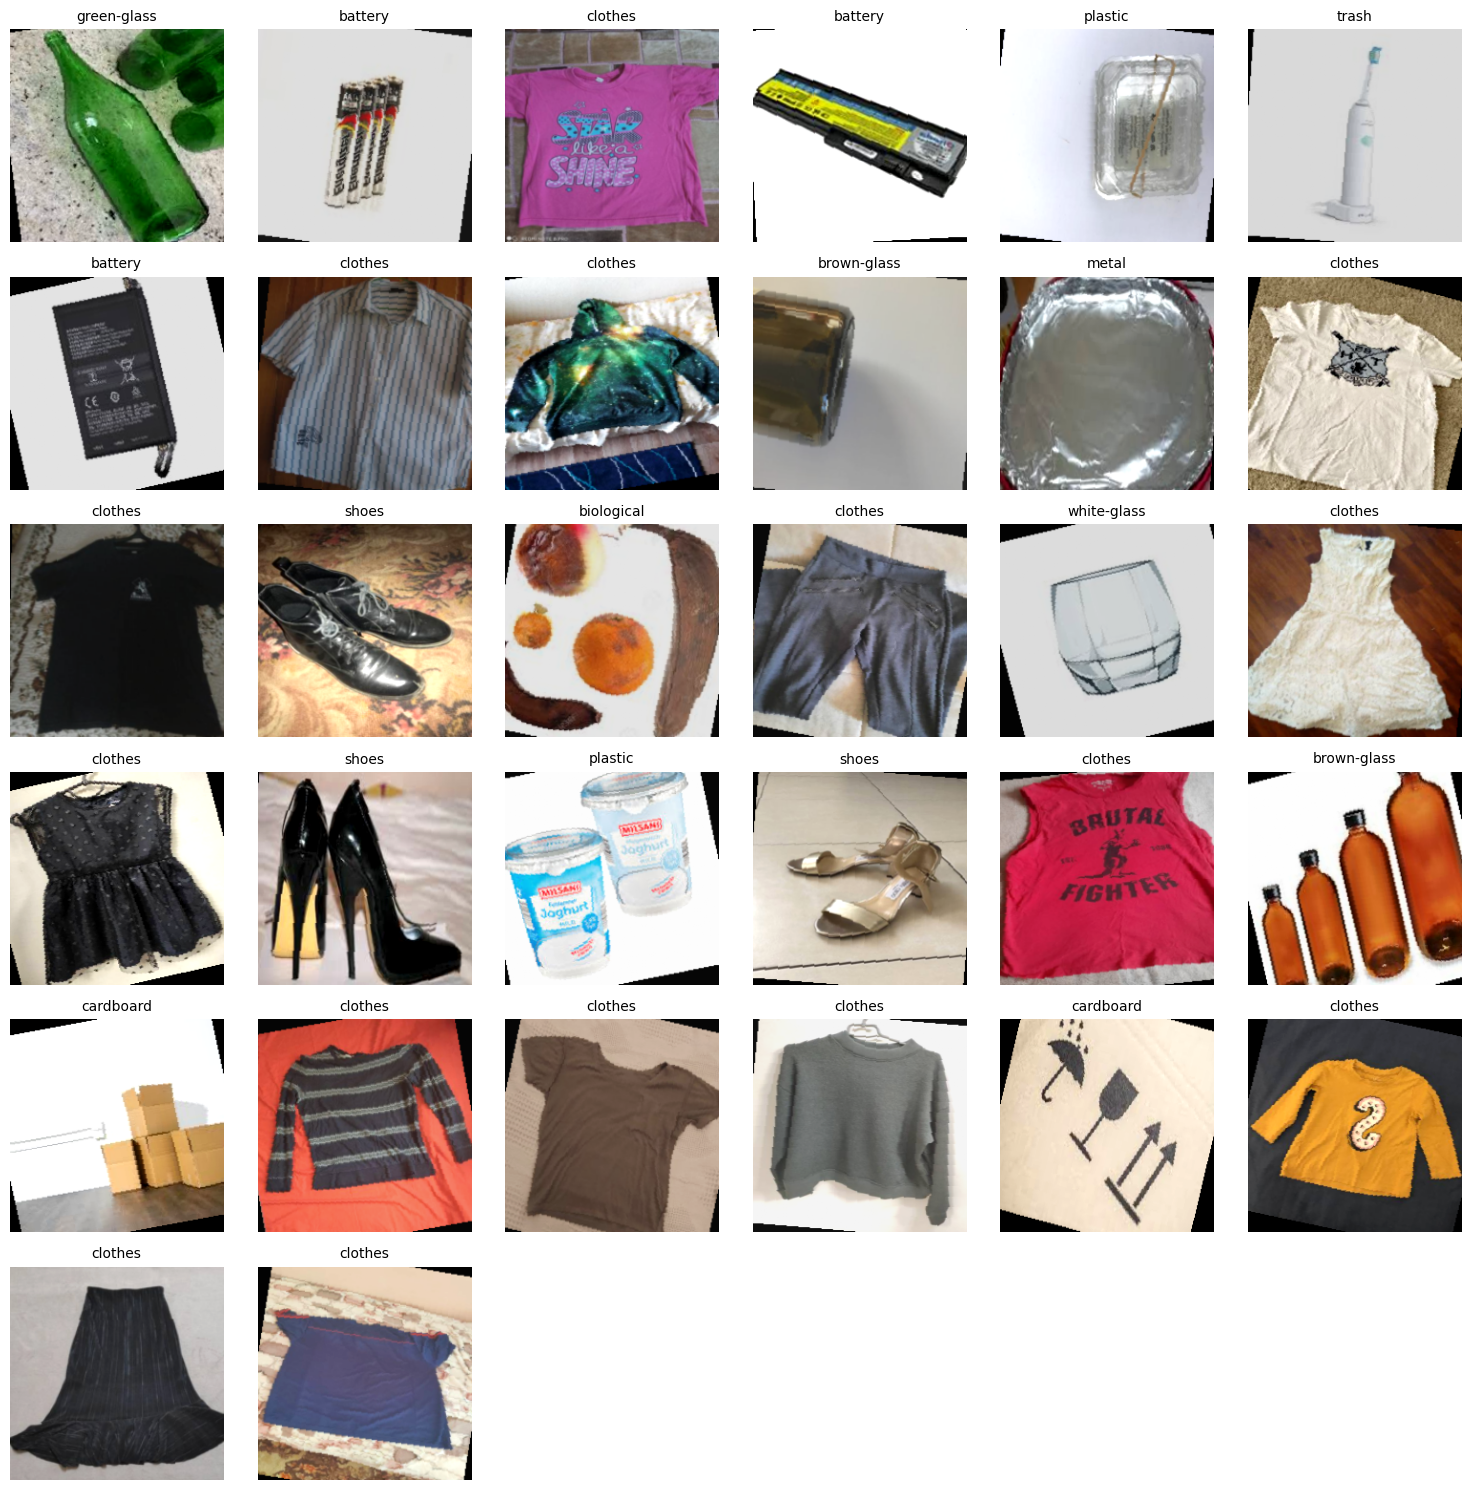

In [34]:
for idx, data in enumerate(train_loader):
  show_images_batch(images_batch=data[0], labels=data[1])
  break

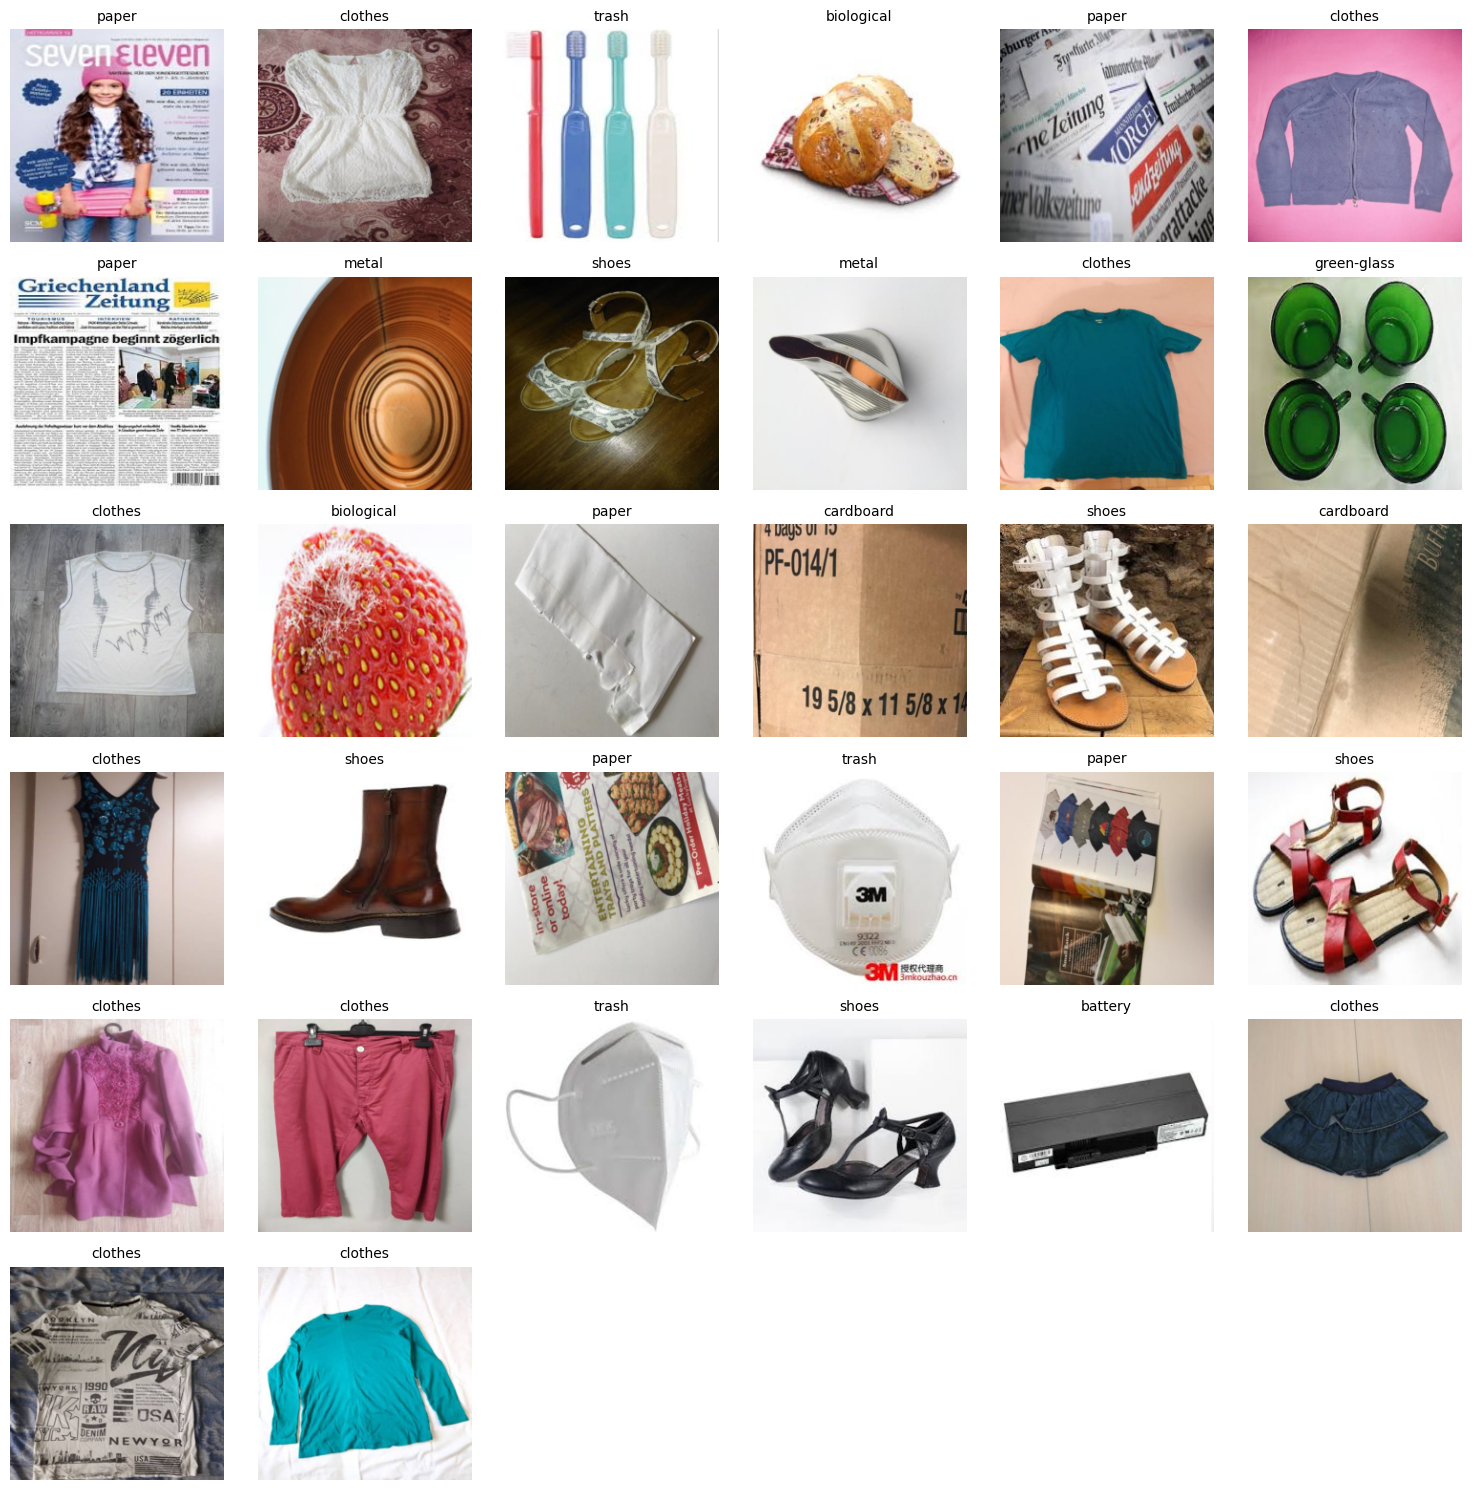

In [35]:
for idx, data in enumerate(val_loader):
  show_images_batch(images_batch=data[0], labels=data[1])
  break

Transfer Learning

In [36]:
resnet_model = torchvision.models.resnet50(weights='IMAGENET1K_V1').cuda()

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 187MB/s]


In [37]:
summary(resnet_model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

Changing output layer

In [38]:
print(resnet_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [39]:
resnet_model.fc = nn.Linear(2048, 12)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.AdamW(resnet_model.parameters(), lr=learning_rate)

resnet_model = resnet_model.cuda()

In [40]:
resnet_model = resnet_model.cuda()

Model Evaluation without modification

In [41]:
val_running_loss = 0.0
val_running_accuracy = 0.0

idx = 0
for idx, data in enumerate(val_loader):

  images, labels = data
  images = images.cuda()
  labels = labels.cuda()

  pred = resnet_model(images)

  loss = loss_fn(pred, labels)

  val_running_loss += loss.item()

  _, pred_arr = torch.max(pred.detach(), 1)
  label_arr = labels.cpu().numpy()

  val_running_accuracy += accuracy_score(label_arr, pred_arr.cpu().numpy())

  if idx == 10:
    break

print(f"Validation Loss is {val_running_loss}")
print(f"Validation Accuracy is {val_running_accuracy/(idx+1)}")

Validation Loss is 27.177003145217896
Validation Accuracy is 0.14204545454545456


retrain only output layer

In [42]:
# all the layers, parameters, weights and bias shown using .parameter()
# .requires_grad_ = False (cannot calculate the backpropagation, weight will not be changed (freeze the model))
for p in resnet_model.parameters():
  p.requires_grad = False

In [43]:
summary(resnet_model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [44]:
resnet_model.fc = nn.Linear(2048, 12)

In [45]:
resnet_model = resnet_model.cuda()

In [46]:
summary(resnet_model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [47]:
best_val_accuracy = 0
for epoch_idx in range(num_epoch):

  train_running_loss = 0.0
  train_running_accuracy = 0.0

  idx = 0
  for idx, data in tqdm(enumerate(train_loader)):

    optimizer.zero_grad()

    images, labels = data
    images = images.cuda()
    labels = labels.cuda()

    pred = resnet_model(images)

    loss = loss_fn(pred, labels)

    loss.backward()
    optimizer.step()

    train_running_loss += loss.item()

    _, pred_arr = torch.max(pred.detach(), 1)
    label_arr = labels.cpu().numpy()
    # training at last layer only

    train_running_accuracy += accuracy_score(label_arr, pred_arr.cpu().numpy())

  print(f"Training Loss at epoch {epoch_idx} is {train_running_loss}")
  print(f"Training Accuracy at epoch {epoch_idx} is {train_running_accuracy/(idx+1)}")

388it [35:35,  5.50s/it]

Training Loss at epoch 0 is 975.5474457740784
Training Accuracy at epoch 0 is 0.05624079528718704



388it [01:43,  3.74it/s]

Training Loss at epoch 1 is 975.3574094772339
Training Accuracy at epoch 1 is 0.05688512518409426



388it [01:40,  3.85it/s]

Training Loss at epoch 2 is 974.695104598999
Training Accuracy at epoch 2 is 0.05543538291605302



388it [01:42,  3.79it/s]

Training Loss at epoch 3 is 975.1772751808167
Training Accuracy at epoch 3 is 0.058426914580265096



388it [01:41,  3.81it/s]

Training Loss at epoch 4 is 975.7749834060669
Training Accuracy at epoch 4 is 0.054376840942562586



388it [01:42,  3.78it/s]

Training Loss at epoch 5 is 974.9117207527161
Training Accuracy at epoch 5 is 0.05951997422680412



388it [01:42,  3.77it/s]

Training Loss at epoch 6 is 975.042206287384
Training Accuracy at epoch 6 is 0.05720729013254787



388it [01:41,  3.82it/s]

Training Loss at epoch 7 is 974.96599650383
Training Accuracy at epoch 7 is 0.05590712444771723



388it [01:41,  3.82it/s]

Training Loss at epoch 8 is 975.6186769008636
Training Accuracy at epoch 8 is 0.056229289396170834



388it [01:42,  3.78it/s]

Training Loss at epoch 9 is 975.6028089523315
Training Accuracy at epoch 9 is 0.056378865979381444


retraining more layers

In [48]:
for n, p in resnet_model.named_parameters():
  print(n)

conv1.weight
bn1.weight
bn1.bias
layer1.0.conv1.weight
layer1.0.bn1.weight
layer1.0.bn1.bias
layer1.0.conv2.weight
layer1.0.bn2.weight
layer1.0.bn2.bias
layer1.0.conv3.weight
layer1.0.bn3.weight
layer1.0.bn3.bias
layer1.0.downsample.0.weight
layer1.0.downsample.1.weight
layer1.0.downsample.1.bias
layer1.1.conv1.weight
layer1.1.bn1.weight
layer1.1.bn1.bias
layer1.1.conv2.weight
layer1.1.bn2.weight
layer1.1.bn2.bias
layer1.1.conv3.weight
layer1.1.bn3.weight
layer1.1.bn3.bias
layer1.2.conv1.weight
layer1.2.bn1.weight
layer1.2.bn1.bias
layer1.2.conv2.weight
layer1.2.bn2.weight
layer1.2.bn2.bias
layer1.2.conv3.weight
layer1.2.bn3.weight
layer1.2.bn3.bias
layer2.0.conv1.weight
layer2.0.bn1.weight
layer2.0.bn1.bias
layer2.0.conv2.weight
layer2.0.bn2.weight
layer2.0.bn2.bias
layer2.0.conv3.weight
layer2.0.bn3.weight
layer2.0.bn3.bias
layer2.0.downsample.0.weight
layer2.0.downsample.1.weight
layer2.0.downsample.1.bias
layer2.1.conv1.weight
layer2.1.bn1.weight
layer2.1.bn1.bias
layer2.1.conv2.we

In [49]:
for p in resnet_model.named_parameters():
  # print(p[0])
  if 'layer4' in p[0]:
    p[1].requires_grad = True

In [50]:
summary(resnet_model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [51]:
best_val_accuracy = 0
for epoch_idx in range(num_epoch):

  train_running_loss = 0.0
  train_running_accuracy = 0.0

  idx = 0
  for idx, data in tqdm(enumerate(train_loader)):

    optimizer.zero_grad()

    images, labels = data
    images = images.cuda()
    labels = labels.cuda()

    pred = resnet_model(images)

    loss = loss_fn(pred, labels)

    loss.backward()
    optimizer.step()

    train_running_loss += loss.item()

    _, pred_arr = torch.max(pred.detach(), 1)
    label_arr = labels.cpu().numpy()


    train_running_accuracy += accuracy_score(label_arr, pred_arr.cpu().numpy())

  print(f"Training Loss at epoch {epoch_idx} is {train_running_loss}")
  print(f"Training Accuracy at epoch {epoch_idx} is {train_running_accuracy/(idx+1)}")

388it [01:46,  3.64it/s]

Training Loss at epoch 0 is 424.49692901968956
Training Accuracy at epoch 0 is 0.737642673048601



388it [01:46,  3.63it/s]

Training Loss at epoch 1 is 147.9042731449008
Training Accuracy at epoch 1 is 0.9041329160530192



388it [01:47,  3.61it/s]

Training Loss at epoch 2 is 98.40303530171514
Training Accuracy at epoch 2 is 0.931298324742268



388it [01:46,  3.66it/s]


Training Loss at epoch 3 is 77.49738276936114
Training Accuracy at epoch 3 is 0.9428732511045655


388it [01:45,  3.67it/s]

Training Loss at epoch 4 is 62.15318283997476
Training Accuracy at epoch 4 is 0.9574627209131076



388it [01:48,  3.59it/s]

Training Loss at epoch 5 is 52.95103251375258
Training Accuracy at epoch 5 is 0.9632616899852725



388it [01:50,  3.53it/s]

Training Loss at epoch 6 is 44.35924913454801
Training Accuracy at epoch 6 is 0.9688190353460973



388it [01:48,  3.57it/s]

Training Loss at epoch 7 is 37.32376323547214
Training Accuracy at epoch 7 is 0.9735824742268041



388it [01:47,  3.61it/s]

Training Loss at epoch 8 is 32.23867533355951
Training Accuracy at epoch 8 is 0.9779892304860088



388it [01:47,  3.62it/s]

Training Loss at epoch 9 is 27.643893071450293
Training Accuracy at epoch 9 is 0.9821083394698086


In [52]:
val_running_loss = 0.0
val_running_accuracy = 0.0
idx = 0
for idx, data in enumerate(val_loader):


  images, labels = data
  images = images.cuda()
  labels = labels.cuda()

  pred = resnet_model(images)

  loss = loss_fn(pred, labels)

  val_running_loss += loss.item()

  _, pred_arr = torch.max(pred.detach(), 1)
  label_arr = labels.cpu().numpy()

  val_running_accuracy += accuracy_score(label_arr, pred_arr.cpu().numpy())


  if idx == 10:
    break

print(f"Validation Loss is {val_running_loss}")
print(f"Validation Accuracy is {val_running_accuracy/(idx+1)}")

Validation Loss is 1.58811473287642
Validation Accuracy is 0.9545454545454546


Plotting Validation Loss/ Accuracy Curves

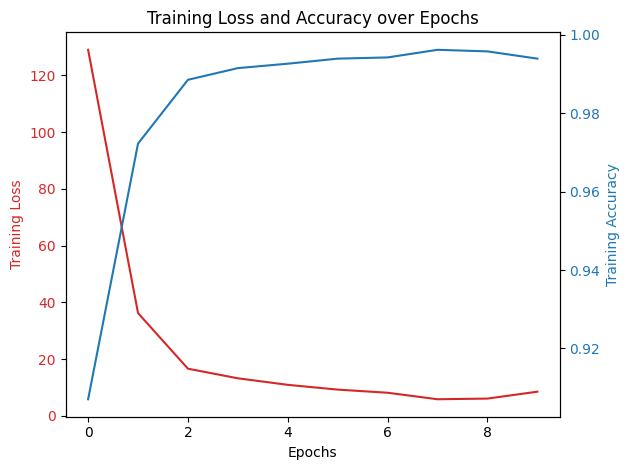

In [53]:
import matplotlib.pyplot as plt

# Data from your training output
epochs = list(range(10))  # Assuming 10 epochs
training_loss = [
    128.9614231940359, 36.21150576369837, 16.62346500949934,
    13.236832838621922, 10.936710711801425, 9.254449758096598,
    8.151131055201404, 5.8591351983486675, 6.095107836124953,
    8.523429761058651
]
training_accuracy = [
    0.9070439064801178, 0.9722823085419735, 0.9885631443298969,
    0.9915431701030928, 0.9926707474226805, 0.9939594072164949,
    0.9942700662739323, 0.9962145618556701, 0.9958118556701031,
    0.9939594072164949
]

# Create a figure with two subplots
fig, ax1 = plt.subplots()

# Plot training loss
color = 'tab:red'
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Training Loss', color=color)
ax1.plot(epochs, training_loss, color=color, label='Training Loss')
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis for training accuracy
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Training Accuracy', color=color)
ax2.plot(epochs, training_accuracy, color=color, label='Training Accuracy')
ax2.tick_params(axis='y', labelcolor=color)

# Title and layout adjustments
plt.title('Training Loss and Accuracy over Epochs')
fig.tight_layout()
plt.show()

In [54]:
# # Plot training metrics and log history of training
# epochs = list(range(10))
# historyplt.figure(figsize= (20, 8))
# plt.style.use('fivethirtyeight')

# # plot two graphs in one space for ease of comparison

# plt.subplot(1, 2, 1)
# plt.plot(Epochs, training_loss, 'r', label= 'Training loss')
# plt.plot(Epochs, val_running_loss, 'g', label= 'Validation loss')
# plt.scatter(index_loss+ 1, val_lowest, s= 150, c= 'blue', label= loss_label)
# plt.title('Training and Validation Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()

# # plot the training and testing accuracy metrices

# plt.subplot(1, 2, 2)
# plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
# plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
# plt.scatter(index_acc+ 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
# plt.title('Training and Validation Accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()

# plt.tight_layout
# plt.show()

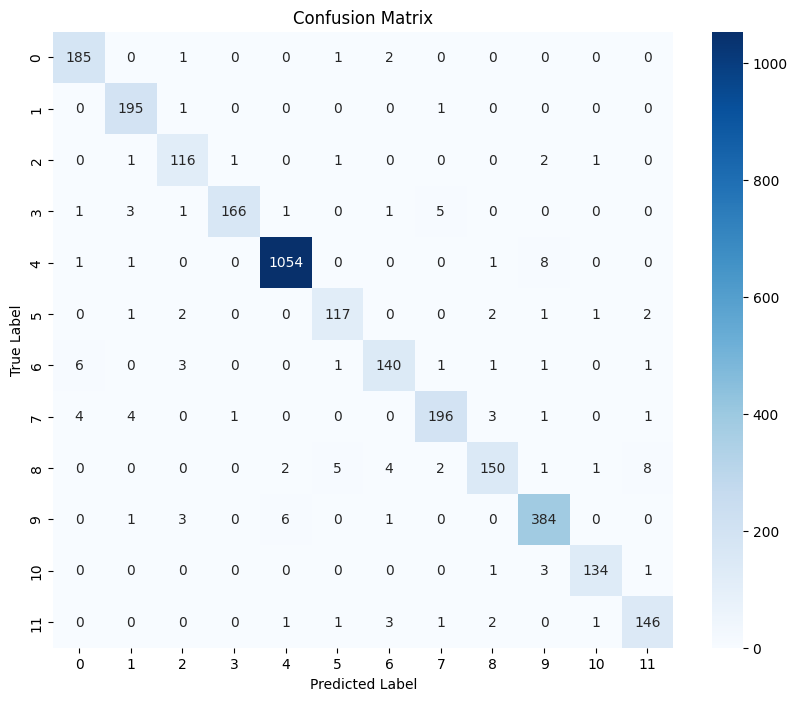

In [55]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

all_labels = []
all_preds = []

for idx, data in enumerate(val_loader):
    images, labels = data
    images = images.cuda()
    labels = labels.cuda()

    pred = resnet_model(images)

    _, pred_arr = torch.max(pred, 1)

    all_labels.extend(labels.cpu().numpy())
    all_preds.extend(pred_arr.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=garbage_class, yticklabels=garbage_class)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [56]:
torch.save(resnet_model, 'garbage_classifier.pt')

In [57]:
import os

# Define your model save path
save_path = '/content/drive/MyDrive/Colab Notebooks/garbage_classification'

# Model and weights save IDs
model_name = "garbage_classifier"
accuracy = 94.88  # Example accuracy; replace with your actual test accuracy
save_id = f'{model_name}-accuracy-{accuracy:.2f}.pt'  # Save file name based on accuracy

# Full model save location
model_save_loc = os.path.join(save_path, save_id)

# Save the model (architecture + weights)
torch.save(resnet_model, model_save_loc)  # Here, only the model and the location is needed
print(f'Model saved as {model_save_loc}')

# Alternatively, save just the model weights (state_dict)
weights_save_id = f'{model_name}-weights.pt'
weights_save_loc = os.path.join(save_path, weights_save_id)

# Save the weights (state_dict)
torch.save(resnet_model.state_dict(), weights_save_loc)  # Only the state_dict and location are needed
print(f'Weights saved as {weights_save_loc}')


Model saved as /content/drive/MyDrive/Colab Notebooks/garbage_classification/garbage_classifier-accuracy-94.88.pt
Weights saved as /content/drive/MyDrive/Colab Notebooks/garbage_classification/garbage_classifier-weights.pt
